In [1]:
import scipy
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from numpy import linalg as LA
from sklearn.metrics.pairwise import euclidean_distances
%config InlineBackend.figure_format = 'retina'

## Q3 $k$ Nearest Neighbor

In [2]:
# 1) Load data.

X_and_Y = np.load('./ionosphere.npy')       # Load data from file.
np.random.seed(0)
np.random.shuffle(X_and_Y)        # Shuffle the data.
X = X_and_Y[:, 0:X_and_Y.shape[1] - 1]       # First column to second last column: Features (numerical values) 
Y = X_and_Y[:, X_and_Y.shape[1] - 1]       # Last column: Labels (0 or 1)
print(X.shape, Y.shape)      # Check the shapes.

(351, 34) (351,)


In [3]:
# 2) Split the dataset into 2 parts: 
#    (a) Training set + Validation set  (First 80% of all data points)
#    (b) Test set                       (Last 20% of all data points)

eighty_percent = round(len(X) * .8)
X_train_val = X[:eighty_percent] # Get features from train + val set.
X_test      = X[eighty_percent:] # Get features from test set.     
Y_train_val = Y[:eighty_percent] # Get labels from train + val set.
Y_test      = Y[eighty_percent:] # Get labels from test set.  
print(X_train_val.shape, X_test.shape, Y_train_val.shape, Y_test.shape)

(281, 34) (70, 34) (281,) (70,)


In [4]:
# 3) Implement the k-NN.
class simple_KNeighborsClassifier(object):
    def __init__(self, k):
        """
        k-NN initialization.
            k: Number of nearest neighbors.
        """
        self.k = k
        
    def fit(self, X_train, Y_train):
        """
        k-NN fitting function.
            X_train: Feature vectors in training set.
            Y_train: Labels in training set.
        """
        self.X_train = X_train
        self.Y_train = Y_train
        
    def predict(self, X_pred):
        """
        k-NN prediction function.
            X_pred: Feature vectors in training set.
        Return the predicted labels for X_pred. Shape: (len(X_pred), ).
        """
        Y_pred = []
        for x in X_pred:
            dists = {}
            for i, self_x in enumerate(self.X_train):
                dists[np.linalg.norm(x - self_x)] = self.Y_train[i]
            dists = sorted(dists.items())
            labels = [i[1] for i in dists[:self.k]]
            Y_pred.append(max(set(labels), key=labels.count))
        return np.array(Y_pred)


In [5]:
# 4) Implement the cross-validation.
#from sklearn.neighbors import KNeighborsClassifier


def score(pred, actual):
    correct = 0
    for i,x in enumerate(pred):
        if(x == actual[i]):
            correct += 1

    return float(correct)/len(pred)

def simple_cross_validation(X_train_val, Y_train_val, k, fold):
    """
    A simple cross-validation function for k-NN.
    
    X_train_val: Features for train and val set. 
                 Shape: (num of data points, num of features)
    Y_train_val: Labels for train and val set.
                 Shape: (num of data points,)
    k:           Parameter k for k-NN.
    fold:        The number of folds to do the cross-validation.
    
    Return the average accuracy on validation set.
    """

    
    val_acc_list = []
    train_acc_list = []
    start = 0
    for i in range(fold):
        end = int(min(round(len(X_train_val) / fold, 0) * (i + 1), len(X_train_val)))
        X_val = X_train_val[start: end]
        Y_val = Y_train_val[start: end]
        X_train = X_train_val[0: start]
        X_train = np.concatenate((X_train, X_train_val[end:]))
        Y_train = Y_train_val[0: start]
        Y_train = np.concatenate((Y_train, Y_train_val[end:]))
        # Actually you can use the built-in function from sklearn
        # to validate if your implementation is correct or not:
        #    
        #sk_classifier  = KNeighborsClassifier(algorithm='brute', n_neighbors=k)
        classifier = simple_KNeighborsClassifier(k=k)
        #sk_classifier.fit(X_train, Y_train)
        classifier.fit(X_train, Y_train)
        val_predict = classifier.predict(X_val)
        train_predict = classifier.predict(X_train)
#         print(f'My val score: {score(val_predict, Y_val)}')
#         print(f'My train score: {score(train_predict, Y_train)}')
        
#         sk_val_predict = sk_classifier.predict(X_val)
#         sk_train_predict = sk_classifier.predict(X_train)
#         print(f'Sklearn val score: {score(Y_val, sk_val_predict)}')
#         print(f'sklearn train score: {score(Y_train, sk_train_predict)}')
#         print('\n')
        
        val_acc_list.append(score(val_predict, Y_val))
        train_acc_list.append(score(train_predict, Y_train))
        
        start = end
        
    return sum(val_acc_list) / len(val_acc_list), \
           sum(train_acc_list) / len(train_acc_list)

In [6]:
# 5) Implement the grid search function.

def simple_GridSearchCV_fit(X_train_val, Y_train_val, k_list, fold):
    """
    A simple grid search function for k with cross-validation in k-NN.
    
    X_train_val: Features for train and val set. 
                 Shape: (num of data points, num of features)
    Y_train_val: Labels for train and val set.
                 Shape: (num of data points,)
    k_list:      The list of k values to try.
    fold:        The number of folds to do the cross-validation.
    
    Return the val and train accuracy matrix of cross-validation. 
    All combinations of k are included in the array. 
    Shape: (len(k_list), )
    """
    val_acc_array = np.empty(len(k_list))
    train_acc_array = np.empty(len(k_list))
    for i, k in enumerate(k_list):
        accs = simple_cross_validation(X_train_val, Y_train_val, k, 3)
        val_acc_array[i] = accs[0]
        train_acc_array[i] = accs[1]
    return val_acc_array, train_acc_array

In [7]:
# 6) Perform grid search.

k_list = list(range(1,7))
val_acc_array, train_acc_array = \
    simple_GridSearchCV_fit(X_train_val, Y_train_val, k_list, 3)
    
# print(f'val_acc_array: {val_acc_array} \n')

# print(f'train_acc_array: {train_acc_array}')

In [8]:
# 7) Draw heatmaps for result of grid search and find 
#    best k on validation set.

def draw_heatmap_knn(acc, acc_desc, k_list):
    plt.figure(figsize = (2,4))
    #ax = sns.heatmap(acc, annot=True, fmt='.3f', yticklabels=k_list, xticklabels=[])
    ax = sns.heatmap(acc, annot=True, yticklabels=k_list, xticklabels=[])
    ax.collections[0].colorbar.set_label("accuracy")
    ax.set(ylabel='$k$')
    plt.title(acc_desc + ' w.r.t $k$')
    sns.set_style("whitegrid", {'axes.grid' : False})
    plt.show()
    
#
# You can use the draw_heatmap_knn() to draw a heatmap to visualize 
# the accuracy w.r.t. k. Some demo code is given below as hint:
#
# demo_acc = np.array([[0.8], [0.7]])
# demo_k_list = [1, 2]
# draw_heatmap_knn(demo_acc, 'demo accuracy', demo_k_list)
#


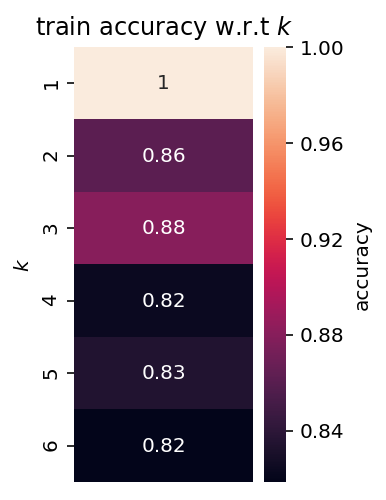

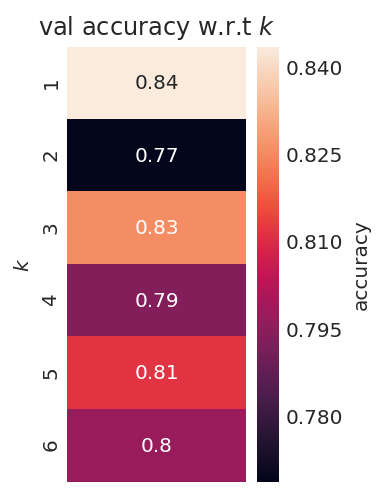

In [9]:
draw_heatmap_knn(train_acc_array.reshape(-1,1), 'train accuracy', k_list)
draw_heatmap_knn(val_acc_array.reshape(-1,1), 'val accuracy', k_list)

In [10]:
# 8) Use the best k to calculate the test accuracy.

classifier = simple_KNeighborsClassifier(k=1)
classifier.fit(X_test, Y_test)
test_pred = classifier.predict(X_test)

# print(f'test_pred: {test_pred}')

# print(f'Y_test: {Y_test}')

score(test_pred, Y_test)

1.0